In [1]:
import pickle
import numpy as np
import pandas as pd
import shap
from imblearn.over_sampling import KMeansSMOTE, SMOTE
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report, make_scorer, accuracy_score, \
    balanced_accuracy_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

from matplotlib import pyplot as plt


Drop unnecessary columns in the dataset.

In [2]:
def clean_dataframe(df):

    df.drop(columns=['name', 'followers', 'commit_count_a', 'source', 'job', 'name_without_spaces',
                     'project', 'index'], inplace=True)
    
    df.drop(columns=['AddSM','DelSM','ChurnSM',"SumAddDelSM"], inplace=True)
    
    for column in  df.columns:
         if "SumAddDel" in column:
            df.drop(columns=[column], inplace=True)


    df['DiP'] = df['DiP'].round()
    df['DiP'].replace(0, 1, inplace=True)

Log columns in the dataset to reduce the skewness in data.

In [3]:
def log_dataframe(df):

    #columns_4_log = ['SumAddDelLOC', 'DiP', 'NoC', 'SumAddDelF',
    #                 'SumAddDelSAM', 'SumAddDelSM', 'AddLOC', 'DelLOC', 'AddSAM', 'DelSAM',
    #                 'AddSM','DelSM']

    columns_4_log = ['SumAddDelLOC', 'DiP', 'NoC', 'SumAddDelF',
                     'SumAddDelSAM', 'AddLOC', 'DelLOC', 'AddSAM', 'DelSAM']


    for column in columns_4_log:
        df[column] = np.log(df[column] + 1)

Returns labels (y)

In [4]:
def get_labels(df):
    df.loc[df['job'] == "SA", 'job'] = "SSE"
    df.loc[df['job'] != "SSE", 'job'] = "NSSE"

    return df["job"]

Scales data according to the scaler given as input

In [5]:
def scaling(scaler, X):
    return scaler.fit_transform(X)

Creates synthetic data with original data using smote method.

In [6]:
def create_synthetic_data(smote, X_scaled, y):
    return smote.fit_resample(X_scaled, y)

Train the classifier with synthetic data an create a classification report on original data

In [7]:
def train_and_classification_report(classifier, X_synthetic, y_synthetic, X_scaled, y):
    classifier.fit(X_synthetic, y_synthetic)
    print(classification_report(y, classifier.predict(X_scaled)))

Scores the classifier using a k-fold (here a Stratified 4-fold with shuffle)
Synthetic data are created to train the classifier for each fold.
Real data are used to compute measures for the classifier.

In [8]:
def stratifiedKFold_scoring(classifier, X, y, smote = None):
    kf = StratifiedKFold(n_splits=4, shuffle=False)#, random_state=0)
    print("===> Start kfold <===")
    scores = {"F1": {"values" : []}, "Recall": {"values" : []},
              "Precision": {"values" : []}, "Balanced\nAccuracy" : {"values" : []}}

    for fold, (train_index, test_index) in enumerate(kf.split(X, y), 1):
        print("=> Fold : ",fold)
        #print("TRAIN:", train_index, "TEST:", test_index)
        
        if isinstance(X, np.ndarray):
            X_train = X[train_index]
            y_train = y[train_index]
            X_test = X[test_index]
            y_test = y[test_index]
        elif isinstance(X, pd.core.frame.DataFrame):
            X_train = X.iloc[train_index]
            y_train = y.iloc[train_index]
            X_test = X.iloc[test_index]
            y_test = y.iloc[test_index]
        else : 
            raise Exception("X should be a Pandas Dataframe of Numpy N dim Array")

        if smote is not None:
            print("smote")
            X_train_synthetic, y_train_synthetic = smote.fit_resample(X_train, y_train)
            classifier.fit(X_train_synthetic, y_train_synthetic)
        else:
            classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)

        f1 = f1_score(y_test, y_pred, pos_label="SSE")
        recall = recall_score(y_test, y_pred, pos_label="SSE")
        precision = precision_score(y_test, y_pred, pos_label="SSE")
        accuracy = balanced_accuracy_score(y_test, y_pred)

        scores["F1"]["values"].append(f1)
        scores["Recall"]["values"].append(recall)
        scores["Precision"]["values"].append(precision)
        scores["Balanced\nAccuracy"]["values"].append(accuracy)

    for key in scores:
        scores[key]["values"] = np.array(scores[key]["values"])
        scores[key]["mean"] = np.mean(scores[key]["values"])
        scores[key]["std"] = np.std(scores[key]["values"])
        scores[key]["ci95"] = np.std(scores[key]["values"]) * 2

        print(key, "mean :%0.4f" % scores[key]["mean"])
        print(key, "std : %0.4f" % scores[key]["std"])
        print(key, "95%% Confidence Interval +/- %0.4f" % (scores[key]["ci95"]))
        print("")
    return scores


In [9]:
scaler = MinMaxScaler(feature_range=(-1,1))
smote = KMeansSMOTE(sampling_strategy='minority', random_state=9090)
classifier = KNeighborsClassifier(algorithm='ball_tree', n_neighbors=4, p=1, weights='distance')

Setting 1:
* kNN classifier by default
* No log transformation
* No scaling
* No data over-sampling

In [10]:
classifier = KNeighborsClassifier()
classifier = RandomForestClassifier(random_state=0)

df = pd.read_csv("merged_2_annotated.csv")
y = get_labels(df)

clean_dataframe(df)

X = df

scores_setting_1 = stratifiedKFold_scoring(classifier,X,y)

classifier.fit(X,y)
# check Important features
feature_importances_df = pd.DataFrame(
    {"feature": list(X.columns), "importance": classifier.feature_importances_}
).sort_values("importance", ascending=False)

# Display
feature_importances_df

===> Start kfold <===
=> Fold :  1
=> Fold :  2
=> Fold :  3
=> Fold :  4
F1 mean :0.7601
F1 std : 0.0285
F1 95% Confidence Interval +/- 0.0571

Recall mean :0.6829
Recall std : 0.0489
Recall 95% Confidence Interval +/- 0.0978

Precision mean :0.8608
Precision std : 0.0312
Precision 95% Confidence Interval +/- 0.0625

Balanced
Accuracy mean :0.8324
Balanced
Accuracy std : 0.0229
Balanced
Accuracy 95% Confidence Interval +/- 0.0459



,feature,importance
15,churnLOC,0.138166
13,AddLOC,0.108535
2,NoNAB,0.094855
6,NonCE,0.087144
16,AddF,0.073445
14,DelLOC,0.070294
4,NoCnII,0.047870
17,DelF,0.043676
5,NoCE,0.042460
3,NoCII,0.040505


Setting 2:
* kNN classifier by default
* No log transformation
* No data over-sampling

In [11]:
scaler = MinMaxScaler(feature_range=(-1,1))
classifier = KNeighborsClassifier()
classifier = RandomForestClassifier(criterion='gini', max_depth=None, max_features='log2', random_state=0, n_estimators=75)


df = pd.read_csv("merged_2_annotated.csv")
y = get_labels(df)

#log_dataframe(df)
clean_dataframe(df)

X = df
#X_scaled = scaling(scaler, X)
print(df.columns)

scores_setting_2 = stratifiedKFold_scoring(classifier,X,y)

Index(['NoC', 'NoAB', 'NoNAB', 'NoCII', 'NoCnII', 'NoCE', 'NonCE', 'NoInEI',
       'NoIEI', 'AddLGM', 'DelLGM', 'ChurnGM', 'NoMGM', 'AddLOC', 'DelLOC',
       'churnLOC', 'AddF', 'DelF', 'AddSAM', 'DelSAM', 'ChurnSAM', 'DiP',
       'ICT'],
      dtype='object')
===> Start kfold <===
=> Fold :  1
=> Fold :  2
=> Fold :  3
=> Fold :  4
F1 mean :0.7591
F1 std : 0.0229
F1 95% Confidence Interval +/- 0.0458

Recall mean :0.6933
Recall std : 0.0389
Recall 95% Confidence Interval +/- 0.0777

Precision mean :0.8412
Precision std : 0.0327
Precision 95% Confidence Interval +/- 0.0654

Balanced
Accuracy mean :0.8359
Balanced
Accuracy std : 0.0182
Balanced
Accuracy 95% Confidence Interval +/- 0.0363



Setting 3:
* kNN classifier by default
* Log transformation
* No data over-sampling

In [12]:
scaler = MinMaxScaler(feature_range=(-1,1))
classifier = KNeighborsClassifier()
classifier = RandomForestClassifier(criterion='gini', max_depth=None, max_features='log2', random_state=0, n_estimators=75)


df = pd.read_csv("merged_2_annotated.csv")
y = get_labels(df)

log_dataframe(df)
clean_dataframe(df)

X = df
X_scaled = scaling(scaler, X)

scores_setting_3 = stratifiedKFold_scoring(classifier,X_scaled,y)

===> Start kfold <===
=> Fold :  1
=> Fold :  2
=> Fold :  3
=> Fold :  4
F1 mean :0.7654
F1 std : 0.0555
F1 95% Confidence Interval +/- 0.1111

Recall mean :0.7033
Recall std : 0.0633
Recall 95% Confidence Interval +/- 0.1267

Precision mean :0.8411
Precision std : 0.0549
Precision 95% Confidence Interval +/- 0.1098

Balanced
Accuracy mean :0.8409
Balanced
Accuracy std : 0.0339
Balanced
Accuracy 95% Confidence Interval +/- 0.0678



Setting 4:
* kNN classifier optimized by Grid-Search
* Log transformation
* No data over-sampling

In [13]:
scaler = MinMaxScaler(feature_range=(-1,1))
classifier = KNeighborsClassifier(algorithm='ball_tree', n_neighbors=4, p=1, weights='distance')
classifier = RandomForestClassifier(criterion='gini', max_depth=None, max_features='log2', random_state=0, n_estimators=75)

df = pd.read_csv("merged_2_annotated.csv")
y = get_labels(df)

log_dataframe(df)
clean_dataframe(df)

X = df
X_scaled = scaling(scaler, X)

scores_setting_4 = stratifiedKFold_scoring(classifier,X_scaled,y)


===> Start kfold <===
=> Fold :  1
=> Fold :  2
=> Fold :  3
=> Fold :  4
F1 mean :0.7654
F1 std : 0.0555
F1 95% Confidence Interval +/- 0.1111

Recall mean :0.7033
Recall std : 0.0633
Recall 95% Confidence Interval +/- 0.1267

Precision mean :0.8411
Precision std : 0.0549
Precision 95% Confidence Interval +/- 0.1098

Balanced
Accuracy mean :0.8409
Balanced
Accuracy std : 0.0339
Balanced
Accuracy 95% Confidence Interval +/- 0.0678



Setting 5:
* kNN classifier optimized by Grid-Search
* Log transformation
* Data over-sampling

In [14]:
scaler = MinMaxScaler(feature_range=(-1,1))
smote = KMeansSMOTE(sampling_strategy='minority', random_state=9090)
#classifier = KNeighborsClassifier(algorithm='ball_tree', n_neighbors=4, p=1, weights='distance')
#classifier = RandomForestClassifier(criterion='gini', max_depth=None, max_features='log2', n_estimators=150, random_state=9090)
#classifier = RandomForestClassifier(random_state=0)
classifier = RandomForestClassifier(criterion='gini', max_depth=None, max_features='log2', random_state=0, n_estimators=75)


df = pd.read_csv("merged_2_annotated.csv")
y = get_labels(df)


log_dataframe(df)
clean_dataframe(df)

X = df
X_scaled = scaling(scaler, X)
#X_scaled = X
scores_setting_5 = stratifiedKFold_scoring(classifier,X_scaled,y,smote)
pickle.dump(classifier, open("classifier_rf_model.pkl", 'wb'))

#print(scores_setting_5)

===> Start kfold <===
=> Fold :  1
smote
=> Fold :  2
smote
=> Fold :  3
smote
=> Fold :  4
smote
F1 mean :0.7887
F1 std : 0.0265
F1 95% Confidence Interval +/- 0.0529

Recall mean :0.7446
Recall std : 0.0354
Recall 95% Confidence Interval +/- 0.0708

Precision mean :0.8390
Precision std : 0.0219
Precision 95% Confidence Interval +/- 0.0438

Balanced
Accuracy mean :0.8607
Balanced
Accuracy std : 0.0182
Balanced
Accuracy 95% Confidence Interval +/- 0.0364



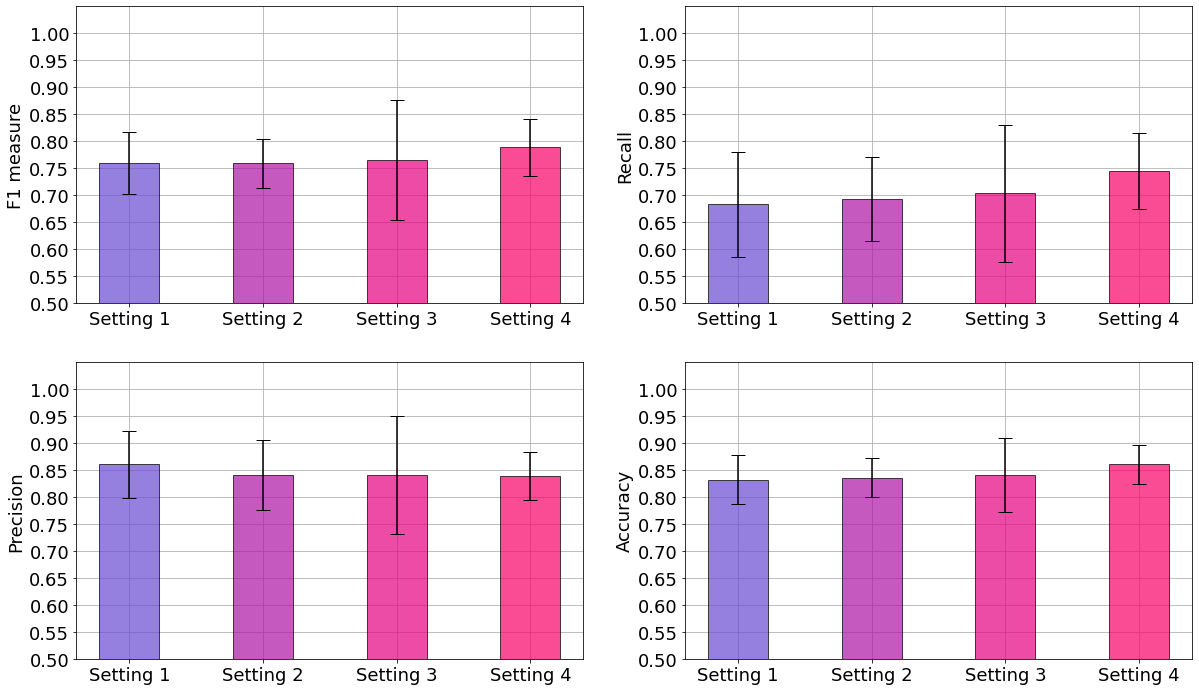

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(20, 12))

scores_settings = [scores_setting_1, scores_setting_2, scores_setting_4,scores_setting_5]
#scores_settings = [scores_setting_1, scores_setting_2, scores_setting_3,scores_setting_4, scores_setting_5]


labels = ['Setting 1', 'Setting 2', 'Setting 3', 'Setting 4']
#labels = ['Config 1', 'Config 2', 'Config 3', 'Config 4', 'Config 5']

xtick_size = 18
label_size = 18

bars= []
metrics = {"F1":"F1-mesure", "Recall":"Rappel", 
           "Precision":"Précision", "Balanced\nAccuracy":"Accuracy"}
metrics = {"F1":"F1 measure", "Recall":"Recall", 
           "Precision":"Precision", "Balanced\nAccuracy":"Accuracy"}
#colors=['#4b51d1','#694BD2', '#AE13A6', '#E60080', '#F70069']
colors=['#694BD2', '#AE13A6', '#E60080', '#F70069']

# "nice" if is_nice else "not nice"
bar_index = 0
for scores_setting in scores_settings :
    j = 0
    for metric in list(metrics.keys()):
        results = scores_setting[metric]

        n = len(labels)-4
        index = np.arange(0, n * 2.0, 2.0)
        bar_width = 0.45
        opacity = 0.7
        x = 1 if j > 1 else 0
        y = j % 2

        axs[x, y].grid(b=True, which='major', linestyle='-', zorder=0)
        bars.append(axs[x, y].bar(bar_index, results["mean"],
                              bar_width,
                              yerr=results["ci95"], capsize=7, edgecolor='black',
                              alpha=opacity, zorder=3, color=colors[bar_index])) #, , label=project[3:4], zorder=3))

        # ax.set_xlabel('Settings')
        axs[x, y].set_ylabel(metrics[metric], fontsize=label_size)
        # axs[x, y].set_ylabel(metric, fontsize=label_size)
        axs[x, y].set_ylim(0.50,1.05)

        # ax.set_title('Milan v/s Inter v/s Juventus')
        axs[x, y].set_xticks(index + bar_width + 0.25)
        axs[x, y].set_yticks(np.arange(0.50, 1.02, 0.05))
        axs[x, y].set_xticks(range(0, len(labels)))
        axs[x, y].set_xticklabels(labels)
        axs[x, y].tick_params(axis='both', which='major', labelsize=xtick_size)
        #axs[x, y].tick_params(axis='both', which='minor', labelsize=16)
        #axs[x, y].legend(ncol=1)
        #plt.setp(axs[x, y].get_legend().get_texts(), fontsize='18')

        j += 1
    bar_index += 1

plt.show()
